In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io
from scipy.sparse import csr_matrix
from scipy.sparse import linalg

Setup for processing

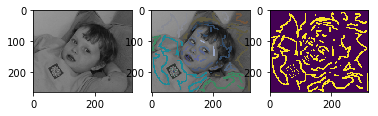

(265, 320)


In [2]:
g_name = cv2.imread('example.bmp') 

plt.subplot(131)
plt.imshow(g_name)

c_name = cv2.imread('example_marked.bmp') 
plt.subplot(132)
plt.imshow(c_name)

gI = np.copy(g_name).astype('float64')/255
cI = np.copy(c_name).astype('float64')/255
colorIm = (np.sum(abs(gI-cI), 2)>0.01)
colorIm = colorIm.astype('float64')
plt.subplot(133)
plt.imshow(colorIm)
plt.show()
print colorIm.shape

(265, 320, 3)


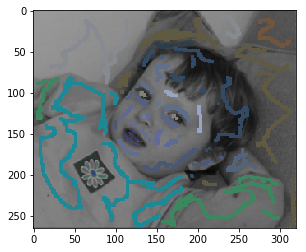

In [3]:
# myimage = cv2.imread('gili_m.png') # read image in as BGR need to convert to YUV
# myimage = io.imread('https://www.cs.huji.ac.il/~yweiss/Colorization/gray/gili_m.bmp') # reading image from research paper
myimage=c_name
print myimage.shape
plt.imshow(myimage)
plt.show()

In [4]:
sgI=cv2.cvtColor(g_name,cv2.COLOR_BGR2YUV)
sgI= sgI.astype('float64')/255
scI=cv2.cvtColor(c_name,cv2.COLOR_BGR2YUV)
scI= scI.astype('float64')/255
print scI.shape  # background on yuv https://en.wikipedia.org/wiki/YUV

# y=scI[:,:,0] # intensity
# plt.subplot(131)
# plt.imshow(y, cmap='gray')
# u=scI[:,:,1] # color
# plt.subplot(132)
# plt.imshow(u, cmap='gray')
# v= scI[:,:,2] # color
# plt.subplot(133)
# plt.imshow(v, cmap='gray')
# plt.show()

(265, 320, 3)


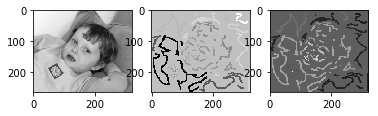

In [5]:
YUV_image= np.zeros(g_name.shape)
YUV_image[:,:,0]=sgI[:,:,0]
YUV_image[:,:,1]=scI[:,:,1]
YUV_image[:,:,2]=scI[:,:,2]
y=YUV_image[:,:,0] # intensity
plt.subplot(131)
plt.imshow(y, cmap='gray')
u=YUV_image[:,:,1] # color
plt.subplot(132)
plt.imshow(u, cmap='gray')
v= YUV_image[:,:,2] # color
plt.subplot(133)
plt.imshow(v, cmap='gray')
plt.show()

In [6]:
# print min(YUV_image.shape[0:1])
# print YUV_image.shape[1]
max_d = np.floor(np.log(min(YUV_image.shape[0:1]))/np.log(2)-2).astype('int')
# print max_d
window_function=2**(max_d-1)
iu= np.floor(YUV_image.shape[0]/(window_function)*(window_function)).astype('int')
ju= np.floor(YUV_image.shape[1]/(window_function)*(window_function)).astype('int')
print iu, ju
id=0
jd=0
print id, iu, jd, ju
colorIm = colorIm[id:iu, jd:ju].copy()  #a deviation from the matlab code- 
YUV_image = YUV_image[id:iu, jd:ju].copy()
print colorIm.shape


256 320
0 256 0 320
(256, 320)


n, m, imgSize: 256 320 81920


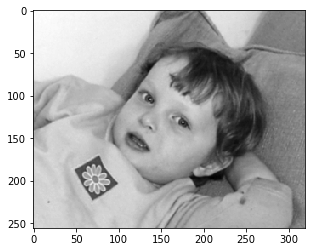

(256, 320)
(256, 320)
col_inds shape:  (737280,)
(256, 320)


In [7]:
# Start getColorExact code

n= YUV_image.shape[0]
m= YUV_image.shape[1]
imgSize=n*m
print "n, m, imgSize:", n,m, imgSize

newImage = np.zeros(YUV_image.shape).astype('float64')
newImage[:,:,0]= YUV_image[:,:,0]  # intensities are still the same; UV changes 

# print newImage[:,:,0]
plt.imshow(newImage[:,:,0], cmap='gray')
plt.show()
# newImageRGB=cv2.cvtColor((255*newImage).astype('uint8'),cv2.COLOR_YUV2BGR)
# plt.imshow(newImageRGB)
# plt.show()
index_matrix=np.arange(imgSize).reshape((n,m), order='F').copy() #matlab reshape is weird
print index_matrix.shape
print colorIm.shape

wd=1




window_size=(imgSize*(2*wd+1)**2)
col_inds=np.zeros(window_size).astype('int64')
row_inds=np.zeros(window_size).astype('int64')

vals=np.zeros(window_size).astype('int64')

print "col_inds shape: ", col_inds.shape
print colorIm.shape

In [8]:
# loops
gvals=np.zeros((2*wd+1)**2)
print "gval shape: ", gvals.shape
print "gvals", gvals

consts_len=0
len=0

for j in range(m):
    for i in range(n):
       # print consts_len, colorIm[i,j]
        
        if (not colorIm[i,j]):
        #    print consts_len, "NOT"
            tlen=0
#             print max(1, i-wd), min(i+wd,n)
            for ii in range(max(0, i-wd), min(i+wd+1,n)): 
                for jj in range(max(0, j-wd), min(j+wd+1,m)):
#                     print "ii: ", ii, "jj: ", jj
                    if (ii!=i) | (jj!=j):
#                         print ii, i, jj,j, "NOT"
#                         print tlen
                        row_inds[len]=consts_len
                        col_inds[len]=index_matrix[ii,jj]
                        
                        gvals[tlen]=YUV_image[ii,jj,0]
#                         print YUV_image[ii,jj,0]
                        len=len+1  # need to move - different from matlab code
                        tlen=tlen+1
                        
#             print gvals  
#             print min(gvals)
#             print tlen
            t_val=YUV_image[i,j,0]
#             print YUV_image[i,j,0]
            gvals[tlen]=t_val
            c_var=np.mean((gvals[0:tlen+1]-np.mean(gvals[0:tlen+1]))**2)
            csig=c_var*0.6
            mgv=min((gvals[0:tlen+1]-t_val)**2)
            if (csig<(-mgv/np.log(0.01))):
                csig=-mgv/np.log(0.01)
            if (csig<0.000002):
                csig=0.000002
            gvals[0:tlen]=np.exp(-(gvals[0:tlen]-t_val)**2/csig)
            gvals[0:tlen]=gvals[0:tlen]/np.sum(gvals[0:tlen])
            vals[len-tlen:len]=-gvals[0:tlen]            
        
        row_inds[len]=consts_len
        col_inds[len]=index_matrix[i,j]
        vals[len]=1
        len=len+1
        consts_len=consts_len+1

gval shape:  (9,)
gvals [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [9]:
vals=vals[0:len]
col_inds=col_inds[0:len]
row_inds=row_inds[0:len]

In [10]:
#sparse it up
print row_inds.shape, col_inds.shape, vals.shape
print consts_len, imgSize
# csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
A=csr_matrix((vals, (row_inds, col_inds)), shape= (consts_len, imgSize))
b=np.zeros(A.shape[0])

label_indices = np.array(np.nonzero(colorIm.flatten('F')))
# print label_indices
print "label indices shape",label_indices.shape
print "b shape", b.shape
print A
print b
for t in [1,2]:
    print t
    curIm=YUV_image[:,:,t].reshape(imgSize, order='F')
    b[label_indices]=curIm[label_indices]
    lucky_charms= linalg.spsolve(A,b)
#     lucky_charms= np.linalg.solve(A.todense(),b)
    newImage[:,:,t]=lucky_charms.reshape((n,m),order='F')

(600153,) (600153,) (600153,)
81920 81920
label indices shape (1, 16822)
b shape (81920,)
  (0, 0)	1
  (0, 1)	0
  (0, 256)	0
  (0, 257)	0
  (1, 0)	0
  (1, 1)	1
  (1, 2)	0
  (1, 256)	0
  (1, 257)	0
  (1, 258)	0
  (2, 1)	0
  (2, 2)	1
  (2, 3)	0
  (2, 257)	0
  (2, 258)	0
  (2, 259)	0
  (3, 2)	0
  (3, 3)	1
  (3, 4)	0
  (3, 258)	0
  (3, 259)	0
  (3, 260)	0
  (4, 3)	0
  (4, 4)	1
  (4, 5)	0
  :	:
  (81895, 81895)	1
  (81896, 81896)	1
  (81897, 81897)	1
  (81898, 81898)	1
  (81899, 81899)	1
  (81900, 81900)	1
  (81901, 81901)	1
  (81902, 81902)	1
  (81903, 81903)	1
  (81904, 81904)	1
  (81905, 81905)	1
  (81906, 81906)	1
  (81907, 81907)	1
  (81908, 81908)	1
  (81909, 81909)	1
  (81910, 81910)	1
  (81911, 81911)	1
  (81912, 81912)	1
  (81913, 81913)	1
  (81914, 81914)	1
  (81915, 81915)	1
  (81916, 81916)	1
  (81917, 81917)	1
  (81918, 81918)	1
  (81919, 81919)	1
[ 0.  0.  0. ...,  0.  0.  0.]
1
2


(array([  0,   1,   2, ..., 255, 255, 255]), array([319, 319, 319, ..., 317, 318, 319]))
(array([  0,   1,   2, ..., 255, 255, 255]), array([319, 319, 319, ..., 317, 318, 319]))


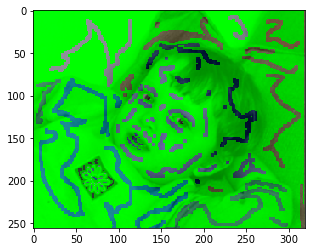

In [11]:
# print newImage
newImage=newImage*255
print np.nonzero(newImage[:,:,1])
print np.nonzero(newImage[:,:,2])
newImage=newImage.astype('uint8')
newImageRGB=cv2.cvtColor(newImage,cv2.COLOR_YUV2BGR)
plt.imshow(newImageRGB)
plt.show()
